# MSDM5002 Final Project 2025

This project features the game Gomuku (aka "Five-in-a-Row", 五子棋). You are asked to create an interactive program which you can play the game with the computer, and later compete with your classmates with your designed strategies. 

---
## 1. Setups

### 1.1. Traditional winning conditions

To make the implementation easier, we will follow the rule of freestyle Gomoku:

- Two players take turns to place their stones (Black or White) onto the chess board. Black always goes first.
- When there are **exactly 5** stones of the same colour forming a continuous chain, the player of that colour wins the game. 
- If the chain is more or less than 5 long, no one wins and the game continues. 
- If there is no more available positions, the game ends in a draw. **Draw is considered as White winning** since it has been theoretically proven that Black (who goes first) has greater advantage over White under the traditional rule. 


### 1.2. Triangular chess board

Different from the traditional $15 \times 15$ square board, you are going to play the game on a triangular board with side length $15$, as illustrated:


<figure style="text-align: center">

</figure>

For easier visual and calculation, we can code the board on a $15\times 15$ square grid, but all the allowed position are above the diagonal. 


<figure style="text-align: center">

</figure>

The equivalent rules for forming chains of 5 are similar to on a square board, however only in horizontal, vertical or upward diagonal directions.

<figure style="text-align: center">
    
</figure>

---
## 2. Skeleton Codes


### 2.1. The chessboard

To save and write data efficiently, the board is recorded as a NumPy array of size $15\times 15$ using the rectangular representation. Therefore the coordinates on the board are exactly the same as the indices in the array.

- Initially, all positions on the board are empty, which are represented by `0`.
- Black and white stones positions are represented by `1` and `-1` respectively.
- Inaccessible positions are represented by `5`.

In the skeleton code, the variable `board` always means the matrix/nested array representation of the chess board. 

- **First dimension** = black axis in above picture = `u`-axis in below code
- **Second dimension** = red axis  in above picture = `v`-axis in below code

In [1]:
import numpy as np

board = np.zeros((15,15), dtype=int)
board[np.triu_indices(15, k=1)] = 5
board = np.flipud(board)

print(board)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 5 5 5 5 5 5 5 5 5 5 5 5 5 5]]


### 2.2. `pygame`

We will be using the package `pygame` to create a graphical user interface. For anaconda user, since `pygame` is not pre-installed with anaconda, you have to install it manually through `pip install pygame` inside conda prompt.

In [2]:
import pygame as pg

# import pygame for the first time will prompt this message

pygame 2.6.1 (SDL 2.28.4, Python 3.13.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


You are not required to build the game from scratch. Most functions for the interactivity have been programmed for you. First of all, here are some utility functions for setting up the chess board. You can use them freely without understanding what they do exactly. `draw_stone()` and `print_winner()` should be the only functions you need to call in your tasks. 

In [3]:
####################################################################################################################
# Hex of different color
color_line = [153, 153, 153]
color_board = [241, 196, 15]
color_black = [0, 0, 0]
color_dark_gray = [75, 75, 75]
color_white = [255, 255, 255]
color_light_gray = [235, 235, 235]
color_red = [255, 0, 0]
color_green= [0, 255, 0]

####################################################################################################################
# create the initial empty chess board in the game window
def draw_board():
    
    global center, sep_x, sep_y, pad_x, pad_y, piece_radius

    sep_x = (w_size - 2*pad)/(tri_span-1)                     # horizontal separation between lines
    sep_y = sep_x*np.sqrt(3)/2                                # vertical separation between lines
    pad_x = pad
    pad_y = w_size/2 - (w_size - 2*pad)*np.sqrt(3)/4
    piece_radius = sep_x*0.3                                  # size of a chess piece

    surface = pg.display.set_mode((w_size, w_size))
    pg.display.set_caption("Gomuku (a.k.a Five-in-a-Row)")
    surface.fill(color_board)

        
    for i in range(tri_span-1):
        pg.draw.line(surface, color_line, (pad+i*sep_x/2, pad_y+i*sep_y),
                     (w_size-pad-i*sep_x/2, pad_y+i*sep_y), 3)
        
        pg.draw.line(surface, color_line, (pad_x+i*sep_x, pad_y),
                     (w_size-pad-(tri_span-i-1)*sep_x/2, pad_y+(tri_span-i-1)*sep_y), 3)
        
        pg.draw.line(surface, color_line, (w_size-pad_x-i*sep_x, pad_y),
                     (pad+(tri_span-i-1)*sep_x/2, pad_y+(tri_span-i-1)*sep_y), 3)

    pg.display.update()
    
    return surface


####################################################################################################################
# translate clicking position on the window to rectangular board indices (u, v)
# pos = (x,y) is a tuple returned by pygame, telling where an event (i.e. player click) occurs on the game window
def click2index(pos):
    
    # check if the clicked position is on the grid
    if ((pos[1]>pad_y-piece_radius) and 
        (pos[0]-pad_x)>(pos[1]-pad_y-piece_radius)/np.sqrt(3) and 
        (pos[0]-w_size+pad_x)<(pad_y+piece_radius-pos[1])/np.sqrt(3)):    

        # return the closest corresponding indices (u,v) on the rectangular representation
        u = round((pos[1]-pad_y)/sep_y)
        v = round((pos[0]-pad_x-u*sep_x/2)/sep_x)
        return (u,v) 
    
    return False    # return False if the clicked position is outside the grid
        
        
        
####################################################################################################################
# Draw the stones on the board at pos = [u, v]
# u and v are the indices on the 15x15 board array (under rectangular grid representation)
# Draw a black circle at pos if color = 1, and white circle at pos if color =  -1

def draw_stone(surface, pos, color=0):
    
    # translate (u, v) indices to xy coordinate on the game window
    x = pad_x+pos[0]*sep_x/2+pos[1]*sep_x
    y = pad_y+pos[0]*sep_y

    if color==1:
        pg.draw.circle(surface, color_black, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_dark_gray, [x, y], piece_radius, 2)
                
    elif color==-1:
        pg.draw.circle(surface, color_white, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_light_gray, [x, y], piece_radius, 2)
        
    pg.display.update()


def draw_highlighted_stone(surface, pos, color=0):
    
    # translate (u, v) indices to xy coordinate on the game window
    x = pad_x+pos[0]*sep_x/2+pos[1]*sep_x
    y = pad_y+pos[0]*sep_y
    
    if color==1:
        pg.draw.circle(surface, color_black, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_red, [x, y], piece_radius, 3)
                
    elif color==-1:
        pg.draw.circle(surface, color_white, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_red, [x, y], piece_radius, 3)
        
    elif color==2:
        pg.draw.circle(surface, color_black, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_green, [x, y], piece_radius, 3)
                
    elif color==-2:
        pg.draw.circle(surface, color_white, [x, y], piece_radius, 0)
        pg.draw.circle(surface, color_green, [x, y], piece_radius, 3)
        
    pg.display.update()
    

####################################################################################################################
# print text on upper left corner
def print_text(surface, msg, color=color_line):
    
    # erase any previous text by covering the area with a rectangle with the same colour as the background
    pg.draw.rect(surface, color_board, pg.Rect(0,0,w_size, pad_y-piece_radius-5), 0)
    
    font = pg.font.Font('freesansbold.ttf', 32)
    text = font.render(msg, True, color)
    textRect = text.get_rect()
    textRect.topleft = (0, 0)
    surface.blit(text, textRect)
    pg.display.update()


def print_winner(surface, winner=0):
    if winner == 2:
        msg = "Draw! So White wins"
        color = color_line
    elif winner == 1:
        msg = "Black wins!"
        color = color_black
    elif winner == -1:
        msg = 'White wins!'
        color = color_white
    else:
        return

    print_text(surface, msg, color)


# display whose current turn is
def print_turn(surface, turn=0):
    
    if turn == 1:
        msg = "Black's turn"
        color = color_black
    elif turn == -1:
        msg = "White's turn"
        color = color_white
    else:
        return
    
    print_text(surface, msg, color)


####################################################################################################################
# a random move generator
def random_move(board, color):
    
    while True:
        indx = (np.random.randint(16), np.random.randint(10))
        if board[indx] == 0:
            return indx


A template of the main function is given to you. First load the above functions and then the below code, you should see a game window poping out. At the moment all you can do is clicking on the board and placing the same colour of stones, and nothing else. 

<figure style="text-align: center">
    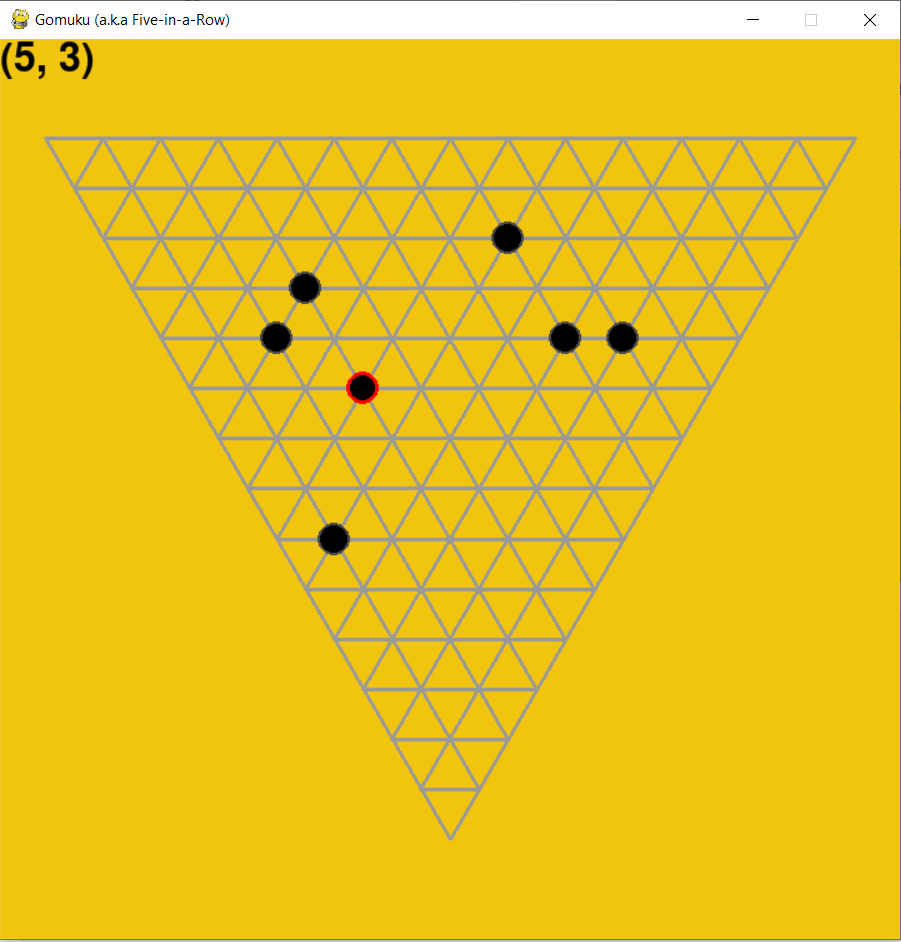
</figure>

In [5]:
import numpy as np
import pygame as pg
import os
os.environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (20,80)

def main_template(player_is_black=True):
    
    global w_size, pad, tri_span
    w_size = 720                                          # window size
    pad = 36                                              # padding size
    tri_span = 15                                         # number of lines on each side
    
    pg.init()
    surface = draw_board()
    
    board = np.zeros((15,15), dtype=int)
    board[np.triu_indices(15, k=1)] = 2
    board = np.flipud(board)
    
    color = 1 if player_is_black else -1      # player's chess pieces color
    indx_mem = (-10, -10)                     # store where the last piece is placed
    running = True
    gameover = False
    
    while running:
        
        ####################################################################################################
        ######################## Normally your edit should be within the while loop ########################
        ####################################################################################################
       
        for event in pg.event.get():              # A for loop to process all the events initialized by the player
            
            # detect if player closes the game window
            if event.type == pg.QUIT:              
                running = False
                
            # detect whether the player is clicking in the window
            # you need to lock the window after gameover
            if event.type == pg.MOUSEBUTTONDOWN and not gameover:

                indx = click2index(event.pos)           # translate clicking position to indices on board matrix indx = (u,v)
                draw_stone(surface, indx_mem, color)    # remove highlight of last move by re-drawing
                
                if indx and board[indx] == 0:           # update the board matrix if that position has not been occupied

                    indx_mem = indx
                    board[indx] = color
                    draw_highlighted_stone(surface, indx, color)
                    
                    
                    print_text(surface, str(indx), color)     # printing any text is optional. You can use it for testing


        ####################################################################################################
        ######################## Normally Your edit should be within the while loop ########################
        ####################################################################################################
        
    pg.quit()
    
    
if __name__ == '__main__':
    main_template(False)

ValueError: invalid color argument

**Note:** When you encounter an error while testing your code, the pygame window will freeze. Trying to close the window will force python to restart the kernal. To avoid this, you have to manually run `pg.quit()` in the console/another notebook cell to kill the process.

In [6]:
pg.quit()

---
## 3. Tasks

Your tasks are to complete the functionalities of the game. This is a group project and we expect each group to have at most 4 people (you are welcome to work alone though). Please join a group in the Canvas after you have found your groupmates.

### 3.1. Human vs Computer

You have to write at least 3 functions:

- `main()` - The main function that runs the game. You can start by editing the `main_template()` function.

- `check_winner()` - For checking if any of the color wins after each placement.

- `computer_move()` - Control how your program places the stones, given that it knows the board's current configurtaion.  

In [ ]:
def main(player_is_black=True):
    # The only input argument `player_is_black` is to determine if player or the computer goes first
    # Output: The game window pop out and a new game starts
    
    
def check_winner(board):
    # Input: board = current configuration of the 15x15 u-v matrix
    # Output: 1 or -1 to indicate which color wins; 2 if it is a draw; 0 if the game is not yet over
    

def computer_move(board, color):
    # Input: board = current configuration of the 15x15 u-v matrix
    #        color = the stone color of the computer
    # Output: (u, v) = a 1x2 tuple to indicate where the computer should place its next stone 
    
    

Your program should run as follow:

1. Run `main()` to start the game.

2. If `player_is_black` is set to `True`, it waits until the player placing his first black stone. Otherwise the computer places the first black stone. 

3. Then player and computer take turns to place their stones. When the AI decides its move, it will call the `computer_move()` function to output its placing position. The execution of `computer_move()` normally should not take more than 5 seconds.

    - The main strategy should be based on **Monte Carlo Tree Search (MCTS)**.
    - You are encouraged to add other strategies to improve its winning rate. For example, try to occupy the position where your opponent is going to win if he takes that position in the next move. 
    - **Neural networks packages are not allowed.** i.e. Your program should be able to run without installing Tensorflow, Pytorch or similar packages. They are too powerful and are ruining the fun. *You can still use neural network if you can write one without these packages*.
   <br>

4. After each placement (both player and computer), the program should call `check_winner()` to check if any of the colours wins. If yes, then call `print_winner()` to display `Black wins!`, `White wins!`, or `Draw!` in the game window. The screen should then be locked and any player clicking can no longer change the board.

5. Player should be allowed to close the game window at any time. 


### 3.2. Computer vs Computer

At the end of the semester, we will have hold a knockout competition between the programs from each groups. In each battle, I will run your code code in this colab notebook:

https://colab.research.google.com/drive/1t02mGK2kZjlq2Ky_sdWDoK_FjKdFQTOj?usp=sharing

Your submitted .py is expected to run smoothly when imported in this code, otherwise you cannot compete with other groups.

The 4 groups who get into the semi-final round will receive bonus marks.

### 3.3 Submission & Deadlines

**By 12th Dec**

1. Your code (for each group) - A `.py` file that contains the 3 required functions in your tasks, all the utility functions from above, and anything else you added to run your programs.
    - This will be used to import your functions in the competition. 
    - It is ok if you want to separate your functions into different files for better file management. In that case, zip all your files and write a brief documentation on how to run the game and how I can import your game for the competiton. 
    <br>

2. Your report (for each person) - A report (in PDF, expect 2-4 pages but not mandatory) that contains
    - Your understanding to MCTS and how it is used in your project
    - Your contribution and the division of labour in the project
    - A peer evaluation table to give each of your groupmate a participation score (scale: 0-5)
    <br>
    Not submitting the peer evaluation may result in losing your own peer evaluation score.

<br>

**On 17th Dec, 1900-2200, Rm 6591**

We will hold the live inter-group battle in the classroom. You do not have to prepare anything except snacks and drinks.